## 2. Análisis de Sentimiento

Implementación y evaluación de un modelo de análisis de sentimiento.

El objetivo principal es el de realizar un **modelo de clasificación binaria**. Se valorará positivamente comparar la variación en los resultados al usar **diferentes modelos**, al **modificar algún paso en la etapa de preprocesado** (stemming vs no stemming, p.ej.), así como la comparación de resultados utilizando o bien **modelos pre-entrenados** o modelos más simples (como VADER).

Se utilizará alguno de los datasets disponibles de **reviews de Amazon**.

Soluciones más avanzadas como por ejemplo modelos de clasificación multi-clase o basados en embeddings serán valorables.

In [21]:
# Importamos lo que vayamos a necesitar
import pandas as pd
import numpy as np
import string
import random

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel

import pyLDAvis
import pyLDAvis.gensim

from collections import Counter
import matplotlib.pyplot as plt
from stop_words import get_stop_words
from nltk.stem.snowball import EnglishStemmer

# Nuestras funciones del archivo utils, para el procesado del texto
from utils import file_to_dict, process_text

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.preprocessing import OneHotEncoder


from multiprocessing.pool import Pool
from functools import partial
from os import cpu_count

### 1. Importamos y procesamos nuestros datos

In [2]:
data = pd.read_csv('./datasets/reviews.csv')

In [3]:
data['rating_binary_label'] = data['rating'].apply(lambda it: 'pos' if it > 3 else 'neg')

In [4]:
data['rating_triary_label'] = data['rating'].apply(lambda it: 'pos' if it > 3 else ('neu' if it == 3 else 'neg'))

In [5]:
# Vemos que ha creado nuestra neuva columna
data.head()

,review,rating,helpful,category,rating_binary_label,rating_triary_label
0,A fun way to bling up your desk and make sure ...,4,1.0,Office products,pos,pos
1,I continue to love this show. Raylan and the r...,5,0.0,Amazon instant videos,pos,pos
2,Arrived in super flash time. Like another rev...,5,0.0,Patio lawn/garden,pos,pos
3,This treat ball works as expected. I used Temp...,4,0.5,Pet supplies,pos,pos
4,I know it's extrange but it works! It is easy ...,4,0.0,Baby,pos,pos


In [6]:
# Constants
lemas = file_to_dict('./datasets/lemmatization-en.txt')
min_length = 50
en_stop_words = gensim.parsing.preprocessing.STOPWORDS
translate_table = dict((ord(char), None) for char in string.punctuation)  
lang='en'
stemmer = EnglishStemmer(ignore_stopwords=True)

In [7]:
def process_row(row):    
    if type(row['review']) is str:    
        aux = process_text(min_length, lemas, translate_table, en_stop_words, 'en', stemmer, row['review'])
        if aux:
            return {
                'review': ' '.join(aux),
                'review_processed': aux,
                'category': row['category'],
                'rating_binary_label': row['rating_binary_label'],
                'rating_triary_label': row['rating_triary_label']
            }

In [8]:
pool = Pool(cpu_count())
df = [it for it in pool.map(process_row, [row for index, row in data.iterrows()]) if it]
pool.close()
df = pd.DataFrame(list(df))
df.dropna(inplace=True)

In [9]:
df

,review,review_processed,category,rating_binary_label,rating_triary_label
0,bling desk surest want stolen stapler return i...,"[bling, desk, surest, want, stolen, stapler, r...",Office products,pos,pos
1,continu love raylan rest charact southern atmo...,"[continu, love, raylan, rest, charact, souther...",Amazon instant videos,pos,pos
2,arriv super flash time like anoth review hard ...,"[arriv, super, flash, time, like, anoth, revie...",Patio lawn/garden,pos,pos
3,treat ball work expect tempat treat dispens fi...,"[treat, ball, work, expect, tempat, treat, dis...",Pet supplies,pos,pos
4,know extrang works easiest clean eighth month ...,"[know, extrang, works, easiest, clean, eighth,...",Baby,pos,pos
...,...,...,...,...,...
177120,second year happiest strap lock great product,"[second, year, happiest, strap, lock, great, p...",Musical instruments,pos,pos
177121,unit everyth friend dodg intrepid told exact w...,"[unit, everyth, friend, dodg, intrepid, told, ...",Automotive,pos,pos
177122,year smead hang folder plastic remov rarest oc...,"[year, smead, hang, folder, plastic, remov, ra...",Office products,pos,pos
177123,pros need touch dead look cons silver scary ha...,"[pros, need, touch, dead, look, cons, silver, ...",Patio lawn/garden,neg,neu


## Separamos en train test

In [41]:
def train_test_splt(values, labels):
    print('Spliting...')
    return train_test_split(
        values,
        labels,
        train_size=0.75,
        test_size=0.25,
        random_state=42,
        shuffle=True,
        stratify=labels
    )

In [42]:
X_train, X_test, y_train, y_test = train_test_splt(df['review'], df['rating_binary_label'])
X_train, X_validation, y_train, y_validation= train_test_splt(X_train, y_train)

Spliting...
Spliting...


## Extraccion de caracteristicas

In [12]:
def plot_chi_square(values, labels, words_to_show=10): 
    # Compute the chi-squared score for each word in the training set and show the values
    chi2score = chi2(values, labels)[0]
    scores = list(zip(cv.get_feature_names(), chi2score))
    sorted_scores = sorted(scores, key=lambda x:x[1])
    topchi2 = list(zip(*sorted_scores[-words_to_show:]))
    x = range(len(topchi2[1]))
    labels = topchi2[0]

    plt.figure(figsize=(12, 8))
    plt.barh(x,topchi2[1], align='center', alpha=0.5)
    plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
    plt.yticks(x, labels, fontsize=12)
    plt.xlabel(r'$\chi^2$', fontsize=26)
    plt.ylabel('word', fontsize=16)
    plt.title(r'Top {} $\chi^2$ score for each word in the training set'.format(words_to_show), fontsize=20)
    plt.grid()
    plt.tight_layout()
    plt.show();

In [43]:
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=2500,
    strip_accents='ascii',
    ngram_range=(1,2)
)
cv.fit(X_train)

X_train_ = cv.transform(X_train)
X_validation_ = cv.transform(X_validation)
X_test_ = cv.transform(X_test)

TODO ver que hacer con esto

In [ ]:
print(list(cv.vocabulary_.items())[:20])

In [ ]:
words_example = [
    'this',
    'like',
    'good',
    'great',
    'dont',
]

In [ ]:
vocab_idf = dict(zip(cv.get_feature_names(), cv.idf_))

print('{0:20}{1:20}'.format('Palabra', 'IDF'))
for word in words_example:
    if word not in vocab_idf:
        print('{0:20}{1:20}'.format(word, 'OOV'))
    else:
        print('{0:20}{1:2.3f}'.format(word, vocab_idf[word]))

In [ ]:
import random
i = random.randint(0, len(X_train))
print('ID: {}'.format(i))
print('Sentiment: {}'.format(y_train.iloc[i]))
print('Review: {}'.format(X_train.iloc[i]))

In [ ]:
doc_vector = X_train_[i]
df_tfidf = pd.DataFrame(doc_vector.T.todense(), index=cv.get_feature_names(), columns=['tfidf'])
df_tfidf = df_tfidf[df_tfidf['tfidf'] > 0]

top_n = 10
print('Top {} words with highest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[:top_n]))
print('\nTop {} words with lowest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

TODO ver que hacer con esto

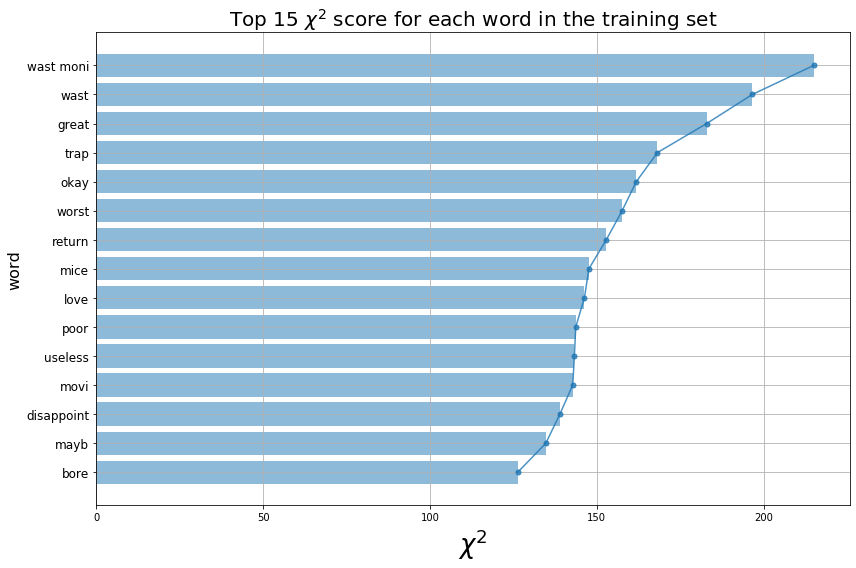

In [44]:
plot_chi_square(X_train_, y_train, 15)

## Evaluacion del modelo

In [45]:
def evaluation(model, values, labels):
    test_predict = model.predict(values)
    print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
    print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
    print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

In [46]:
def plot_values(values, max_idx, labels):
    plt.figure(figsize=(12, 8))
    for d in values:
        plt.plot(d.get('value'), label=d.get('label'))
    plt.axvline(max_idx, c='g', ls='--', alpha=0.8)
    plt.title('Accuracy evolution for different C values')
    plt.xlabel('C')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.xticks(list(range(len(labels))), labels)
    plt.tight_layout()
    plt.show()

In [47]:
def dict_creator(model, tp, vp, tacc, vacc): 
    return {
        'model': model,
        'predictions': {
            'train': tp,
            'validation': vp
        },
        'accuracy': {
            'train': tacc,
            'validation': vacc
        }
    }

In [48]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

def grid_executor(c_params, solvers, max_iter, X_train, y_train, X_val, y_val, multiple_label=False):

    res = []
    for solver in solvers:
        for c in c_params:        
            print(f'Evaluating model with C={c}, solver={solver}, max_iter={max_iter}')
            model = LogisticRegression(C=c, solver=solver, max_iter=max_iter)
            
            if multiple_label:
                model = MultiOutputRegressor(model)
            
            model.fit(X_train_, y_train)

            train_predict = model.predict(X_train_)
            validation_predict = model.predict(X_validation_)
            
            train_acc = accuracy_score(y_train, train_predict)
            validation_acc = accuracy_score(y_val, validation_predict)

            print (f"Accuracy train: {train_acc}, val: {validation_acc}")
            
            res.append(dict_creator(model, train_predict, validation_predict, train_acc, validation_acc))
    return res

In [49]:
def plot_accuracy_evolution(grid):
    train_acc = []
    val_acc = []
    for aux in grid:
        train,val = aux.get('accuracy').values()
        train_acc.append(train)
        val_acc.append(val)

    values = [
        {'label': 'train', 'value': train_acc},
        {'label': 'validation', 'value': val_acc}
    ]

    optimal_model_idx = np.argmax(val_acc)

    plot_values(values, optimal_model_idx, c_params)
    
    return optimal_model_idx

In [50]:


c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]
solvers  = ['lbfgs']
max_iter = 500

grid = grid_executor(c_params, solvers, max_iter, X_train_, y_train, X_validation_, y_validation)


Evaluating model with C=0.01, solver=lbfgs, max_iter=500
Accuracy train: 0.8325839087843263, val: 0.8325855891120412
Evaluating model with C=0.05, solver=lbfgs, max_iter=500
Accuracy train: 0.8404930142925967, val: 0.8401132155008882
Evaluating model with C=0.25, solver=lbfgs, max_iter=500
Accuracy train: 0.8644712542155131, val: 0.8597151546174461
Evaluating model with C=0.5, solver=lbfgs, max_iter=500
Accuracy train: 0.8704633049622611, val: 0.864291951461865
Evaluating model with C=1, solver=lbfgs, max_iter=500
Accuracy train: 0.8741167496386703, val: 0.8663394658396314
Evaluating model with C=10, solver=lbfgs, max_iter=500
Accuracy train: 0.8783924843423799, val: 0.8674535545451808
Evaluating model with C=100, solver=lbfgs, max_iter=500
Accuracy train: 0.8788140356511964, val: 0.8673030020174038
Evaluating model with C=1000, solver=lbfgs, max_iter=500


/home/alberto/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy train: 0.8789244419463627, val: 0.8672126705007377
Evaluating model with C=10000, solver=lbfgs, max_iter=500


/home/alberto/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy train: 0.878994700497832, val: 0.8672126705007377


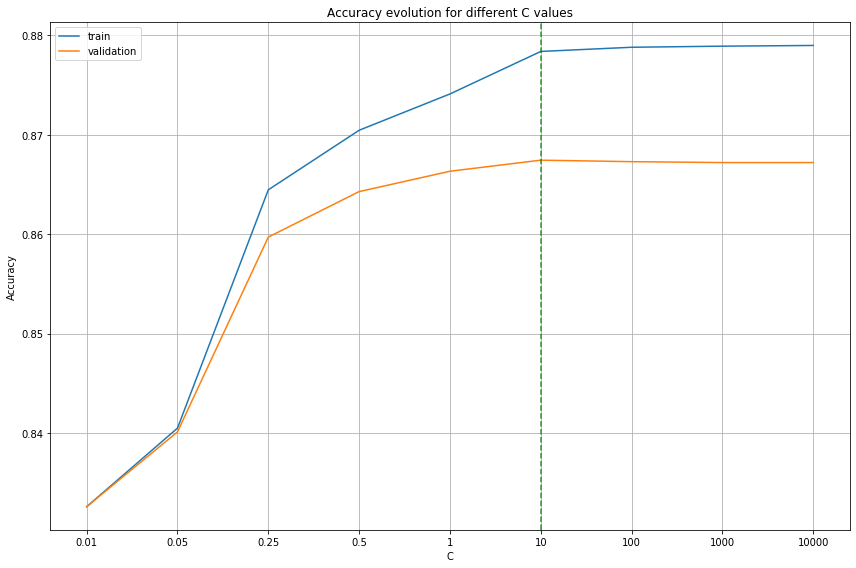

In [53]:
optimal_model_idx = plot_accuracy_evolution(grid)

In [54]:
evaluation(grid[optimal_model_idx].get('model'), X_test_, y_test)

Confussion matrix:
[[ 3044  4370]
 [ 1456 35412]]

Classification report:
              precision    recall  f1-score   support

         neg       0.68      0.41      0.51      7414
         pos       0.89      0.96      0.92     36868

    accuracy                           0.87     44282
   macro avg       0.78      0.69      0.72     44282
weighted avg       0.85      0.87      0.85     44282

Accuracy score:0.8684341267332099


## Comprobamos nuestro modelo

In [55]:
CRED = '\033[41m'
CGREEN = '\033[42m'
CEND = '\033[0m'

In [56]:
def predict_review_sentiment(model, cv, reviews, labels, num_samples):
    predictions = []
    lbls = []
    for i in range(num_samples):
        index = random.choice(X_test.index)
        r = reviews[index]
        
        prediction = model.predict(cv.transform([r]))[0]
        
        predictions.append(prediction)
        lbls.append(labels[index])
        
        color = (CRED, CGREEN)[labels[index] == prediction]
        print(f"Comprobando review {index}")
        print(f"{color}Sentimiento {labels[index]} - {prediction}{CEND}")
    print('Accuracy scorede los elementos de prueba: {}'.format(accuracy_score(lbls, predictions)))

In [57]:
predict_review_sentiment(grid[optimal_model_idx].get('model'), cv, X_test, y_test, 10)

Comprobando review 48742
Sentimiento neg - neg
Comprobando review 105669
Sentimiento pos - pos
Comprobando review 105072
Sentimiento pos - pos
Comprobando review 112207
Sentimiento pos - pos
Comprobando review 145976
Sentimiento pos - neg
Comprobando review 165265
Sentimiento pos - pos
Comprobando review 101738
Sentimiento pos - pos
Comprobando review 84892
Sentimiento pos - pos
Comprobando review 28401
Sentimiento pos - pos
Comprobando review 90511
Sentimiento pos - pos
Accuracy scorede los elementos de prueba: 0.9


Como vemos la moyoria de preducciones con correctas, el menos podemos afirmar eso para unas etiquetas binarias, vamos a probar ahora con 3 'sentimientos'

## Vamos a probar ahora con VADER

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [ ]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))

In [ ]:
sentiment_analyzer_scores("The phone is super cool.")

## Evaluacion para 3 etiquetas

In [58]:
X_train, X_test, y_train, y_test = train_test_splt(df['review'], df['rating_triary_label'])
X_train, X_validation, y_train, y_validation= train_test_splt(X_train, y_train)

Spliting...
Spliting...


In [59]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()

y_train = encoder.fit_transform(y_train)
y_validation = encoder.transform(y_validation)
y_test = encoder.transform(y_test)

In [60]:
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=2500,
    strip_accents='ascii',
    ngram_range=(1,1)
)
cv.fit(X_train)

X_train_ = cv.transform(X_train)
X_validation_ = cv.transform(X_validation)
X_test_ = cv.transform(X_test)

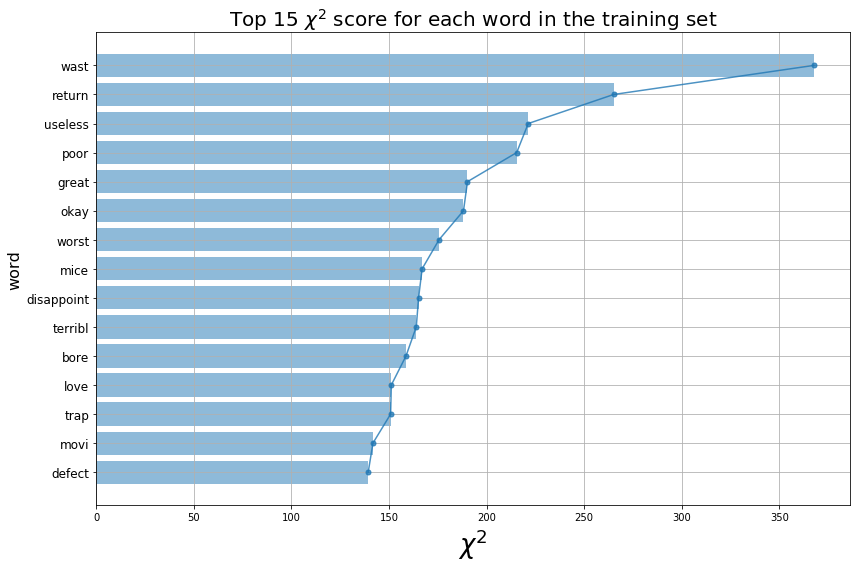

In [61]:
plot_chi_square(X_train_, y_train, 15)

In [62]:

c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100]
solvers  = ['lbfgs']
max_iter = 500

grid = grid_executor(c_params, solvers, max_iter, X_train_, y_train, X_validation_, y_validation, True)


Evaluating model with C=0.01, solver=lbfgs, max_iter=500
Accuracy train: 0.8325738718484021, val: 0.8325855891120412
Evaluating model with C=0.05, solver=lbfgs, max_iter=500
Accuracy train: 0.8311586638830898, val: 0.8305982957453856
Evaluating model with C=0.25, solver=lbfgs, max_iter=500
Accuracy train: 0.8296731973663081, val: 0.8268645930565174
Evaluating model with C=0.5, solver=lbfgs, max_iter=500
Accuracy train: 0.8313895134093464, val: 0.8274366926620698
Evaluating model with C=1, solver=lbfgs, max_iter=500
Accuracy train: 0.8328147583105829, val: 0.8266538195176297
Evaluating model with C=10, solver=lbfgs, max_iter=500
Accuracy train: 0.8354243616508752, val: 0.825359067778748
Evaluating model with C=100, solver=lbfgs, max_iter=500
Accuracy train: 0.8353842139071784, val: 0.8233717744120924


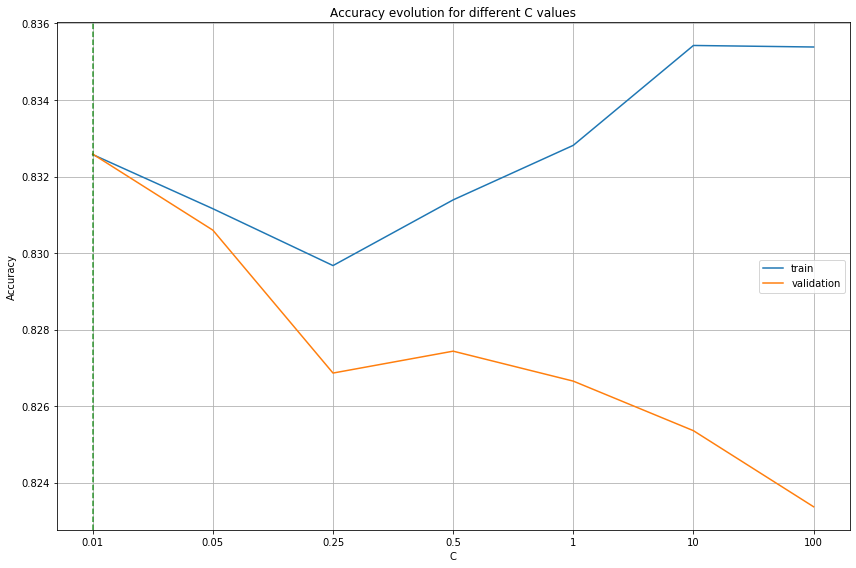

In [63]:
optimal_model_idx = plot_accuracy_evolution(grid)

In [64]:
grid[optimal_model_idx].get('model')

MultiOutputRegressor(estimator=LogisticRegression(C=0.01, class_weight=None,
                                                  dual=False,
                                                  fit_intercept=True,
                                                  intercept_scaling=1,
                                                  l1_ratio=None, max_iter=500,
                                                  multi_class='auto',
                                                  n_jobs=None, penalty='l2',
                                                  random_state=None,
                                                  solver='lbfgs', tol=0.0001,
                                                  verbose=0, warm_start=False),
                     n_jobs=None)

In [65]:
test_predict = grid[optimal_model_idx].get('model').predict(X_test_)
aux1 = encoder.inverse_transform(y_test)
aux2 = encoder.inverse_transform(test_predict)
print('Confussion matrix:\n{}'.format(confusion_matrix(aux1, aux2)))
print('\nClassification report:\n{}'.format(classification_report(aux1, aux2)))
print('Accuracy score:{}'.format(accuracy_score(aux1, aux2)))

Confussion matrix:
[[    0     0  3264]
 [    0     0  4149]
 [    0     0 36869]]

Classification report:
              precision    recall  f1-score   support

         neg       0.00      0.00      0.00      3264
         neu       0.00      0.00      0.00      4149
         pos       0.83      1.00      0.91     36869

    accuracy                           0.83     44282
   macro avg       0.28      0.33      0.30     44282
weighted avg       0.69      0.83      0.76     44282

Accuracy score:0.8325956370534303


/home/alberto/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [66]:
print('Confussion matrix:\n{}'.format(confusion_matrix(encoder.inverse_transform(y_test), encoder.inverse_transform(test_predict))))

Confussion matrix:
[[    0     0  3264]
 [    0     0  4149]
 [    0     0 36869]]


In [37]:
test_predict = grid[optimal_model_idx].get('model').predict(X_test_)

In [81]:
encoder.inverse_transform(test_predict)

array(['pos', 'pos', 'pos', ..., 'pos', 'pos', 'pos'], dtype='<U3')

In [77]:
evaluation(grid[optimal_model_idx].get('model'), X_test_, encoder.inverse_transform(y_test))

ValueError: multilabel-indicator is not supported

In [ ]:
predict_review_sentiment(cv, X_test, y_test, 20)